# Лабороторная работа #6

Выполнил: Китаев Константин, Б01-108

В работе  методом Рунге-Кутты 4 порядка, методом Адамса 4 порядка и ФДН 3го порядка численно решается система двух ОДУ ()

$\begin{array}{ccl}
u' & = & A + u^2v - (B+1)v, & u(0) = 1 \\
v' & = & Bu - u^2v, & v(0) = 1 \\
A = 1; & B \in [1, 5] & & \\
\end{array}$

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
step = 1e-1  # grid step a.k.a. tau

u_0 = 1
v_0 = 1

A = 1
B = 2

In [75]:
def compute_equation_right_part(time, state):
    """Вычисляет правую часть уравнения."""
    # state представляет собой кортеж (u, v), где u и v - состояния системы.
    u, v = state

    # Возвращает новую правую часть уравнения.
    return np.array([
        A + u**2 * v - (B + 1) * v,
        B * u - u**2 * v
    ])


In [76]:
def runge_kutta_method(function, initials, t_max=1000):
    """
    Вычисляет решение дифференциального уравнения методом Рунге-Кутты.
    """

    # Создаём массив начальных условий
    Y = np.array(initials)

    # Создаём пустой массив для хранения решений
    Y_kutta = np.array([[]]).reshape(-1, 2)

    # Вычисляем решения на сетке
    for tau in np.arange(0, t_max, step):
        # Вычисляем значения функции в четырёх точках
        k_1 = function(tau, Y)
        k_2 = function(tau + step / 2, Y + k_1 * step / 2)
        k_3 = function(tau + step / 2, Y + k_2 * step / 2)
        k_4 = function(tau + step, Y + k_3 * step)

        # Вычисляем новое решение
        delta_Y = (k_1 + 2 * k_2 + 2*k_3 + k_4) * step / 6
        Y = Y + delta_Y

        # Добавляем новое решение в массив
        Y_kutta = np.append(Y_kutta, [Y], axis=0)

    return Y_kutta


def adams_method(function, initials, t_max=1000):
    """
    Вычисляет решение дифференциального уравнения методом Адамса.
    """

    # Создаём массив значений времени
    t = np.arange(0, t_max, step)

    # Вычисляем первые 4 значения с помощью метода Рунге-Кутты
    y_adams = runge_kutta_method(function, initials, t_max=4 * step)

    # Выводим размер массива y_adams
    print(y_adams.shape)

    # Вычисляем остальные решения
    for tau in range(4, len(t)):
        # Вычисляем значения функции в четырёх точках
        k_1 = function(tau, y_adams[tau - 1]) * step
        k_2 = function(tau - 1 * step, y_adams[tau - 2]) * step
        k_3 = function(tau - 2 * step, y_adams[tau - 3]) * step
        k_4 = function(tau - 3 * step, y_adams[tau - 4]) * step

        # Вычисляем новое решение
        delta_y = (55 / 24 * k_1 - 59 / 24 * k_2 + 37 / 24 * k_3 - 3 / 8 * k_4)
        new_y = y_adams[tau - 1] + delta_y

        # Добавляем новое решение в массив
        y_adams = np.append(y_adams, [new_y], axis=0)

    return y_adams

def backward_differentiation_formula(function, initials, t_max=1000):
    """
    Вычисляет решение дифференциального уравнения методом обратного дифференцирования.
    """

    # Задаем входные значения
    alpha_arr = np.array([2 / 11, -9 / 11, 18 / 11])
    beta = 6 / 11

    # Создаём массив значений времени
    t = np.arange(0, t_max, step)

    # Вычисляем первое решение с помощью метода Рунге-Кутты
    y_bdf = runge_kutta_method(function, initials, t_max=3 * step)

    # Вычисляем остальные решения
    for tau in range(3, len(t)):
        # Получаем предыдущее решение
        y_last = y_bdf[-1]

        # Вычисляем новое решение
        delta_y = np.dot(alpha_arr, y_bdf[-3:])
        gamma = step * beta
        y_new = gamma * function(tau, y_last) + delta_y

        # Проверяем точность решения
        while (np.linalg.norm(y_last - y_new) > 1e-4):
            y_last = y_new
            y_new = gamma * function(tau, y_last) + delta_y

        # Добавляем новое решение в массив
        y_bdf = np.append(y_bdf, [y_new], axis=0)

    return y_bdf


In [77]:
def plot_3d_phase(data, title=""):
    """
    Построение 3D-графика данных.
    """

    # Создание фигуры с заданным размером
    plt.figure(figsize = (14, 14))

    # Создание осей для 3D графика
    ax = plt.axes(projection = '3d')

    # Установка заголовка графика
    ax.set_title(title)

    # Установка подписей осей
    ax.set_xlabel(r"$u$")
    ax.set_ylabel(r"$v$")
    ax.set_zlabel(r"$t$")

    # Создание массива значений времени
    t = np.arange(0, data.shape[0] * step, step)

    # Построение точек на графике
    ax.scatter3D(data[:, 0], data[:, 1], t, s=0.5)

    plt.show()

def plot_oscillation(data, title="", link_phase_plot_dots=True):
    """
    Построение графика колебаний веществ.
    """

    # Создание массива значений времени
    t = np.arange(0, data.shape[0] * step, step)

    # Создание фигуры с заданным размером и двух осей
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 21), gridspec_kw={'height_ratios': [1, 2]})

    # Установка заголовка графика
    plt.suptitle(title)

    # Добавление сетки на первую ось
    ax1.grid()

    # Ограничение диапазона значений по оси X на первой оси
    ax1.set_xlim(xmin=0, xmax=100)

    # Построение графиков веществ на первой оси
    ax1.plot(t, data[:, 0], label='вещество u')
    ax1.plot(t, data[:, 1], label='вещество v')

    # Настройка подписей осей и заголовка на первой оси
    ax1.set_xlabel('Время, с')
    ax1.set_ylabel('Концентрация')
    ax1.set_title('$u(t),\; v(t)$')
    ax1.legend()

    # Добавление сетки на вторую ось
    ax2.grid()

    # Построение точек на фазовой плоскости
    ax2.scatter(data[:, 0], data[:, 1], s=0.5)

    # Если link_phase_plot_dots == True, то построение линии на фазовой плоскости
    if link_phase_plot_dots:
        ax2.plot(data[:, 0], data[:, 1], linewidth=0.5, color='orange')

    # Настройка подписей осей и заголовка на второй оси
    ax2.set_xlabel('U')
    ax2.set_ylabel('V')
    ax2.set_title('Фазовая плоскость')

    plt.show()

In [78]:
def plot_results(method, order=4, link_phase_plot_dots=True):
    plot_data = method(compute_equation_right_part, [u_0, v_0])
    plot_3d_phase(plot_data, f"Метод {method.__name__} {order}го порядка. A={A}, B={B}")
    plot_oscillation(plot_data, f"Метод {method.__name__} {order}го порядка. A={A}, B={B}", link_phase_plot_dots)


# Результаты

Сначала нужно выполнить все ячейки выше


## A=1, B=2

In [79]:
A = 1
B = 2

### Метод РК-4:

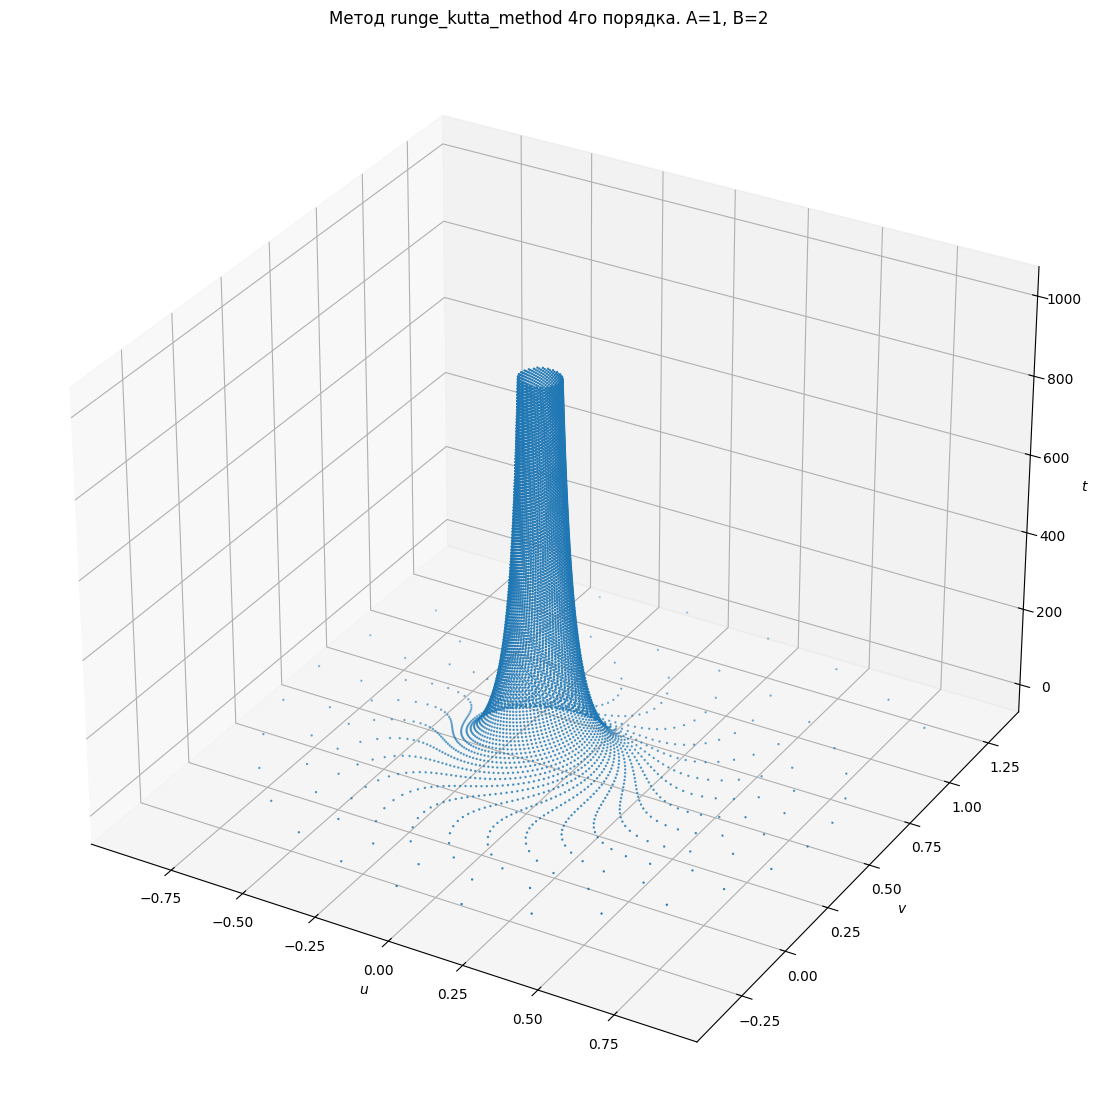

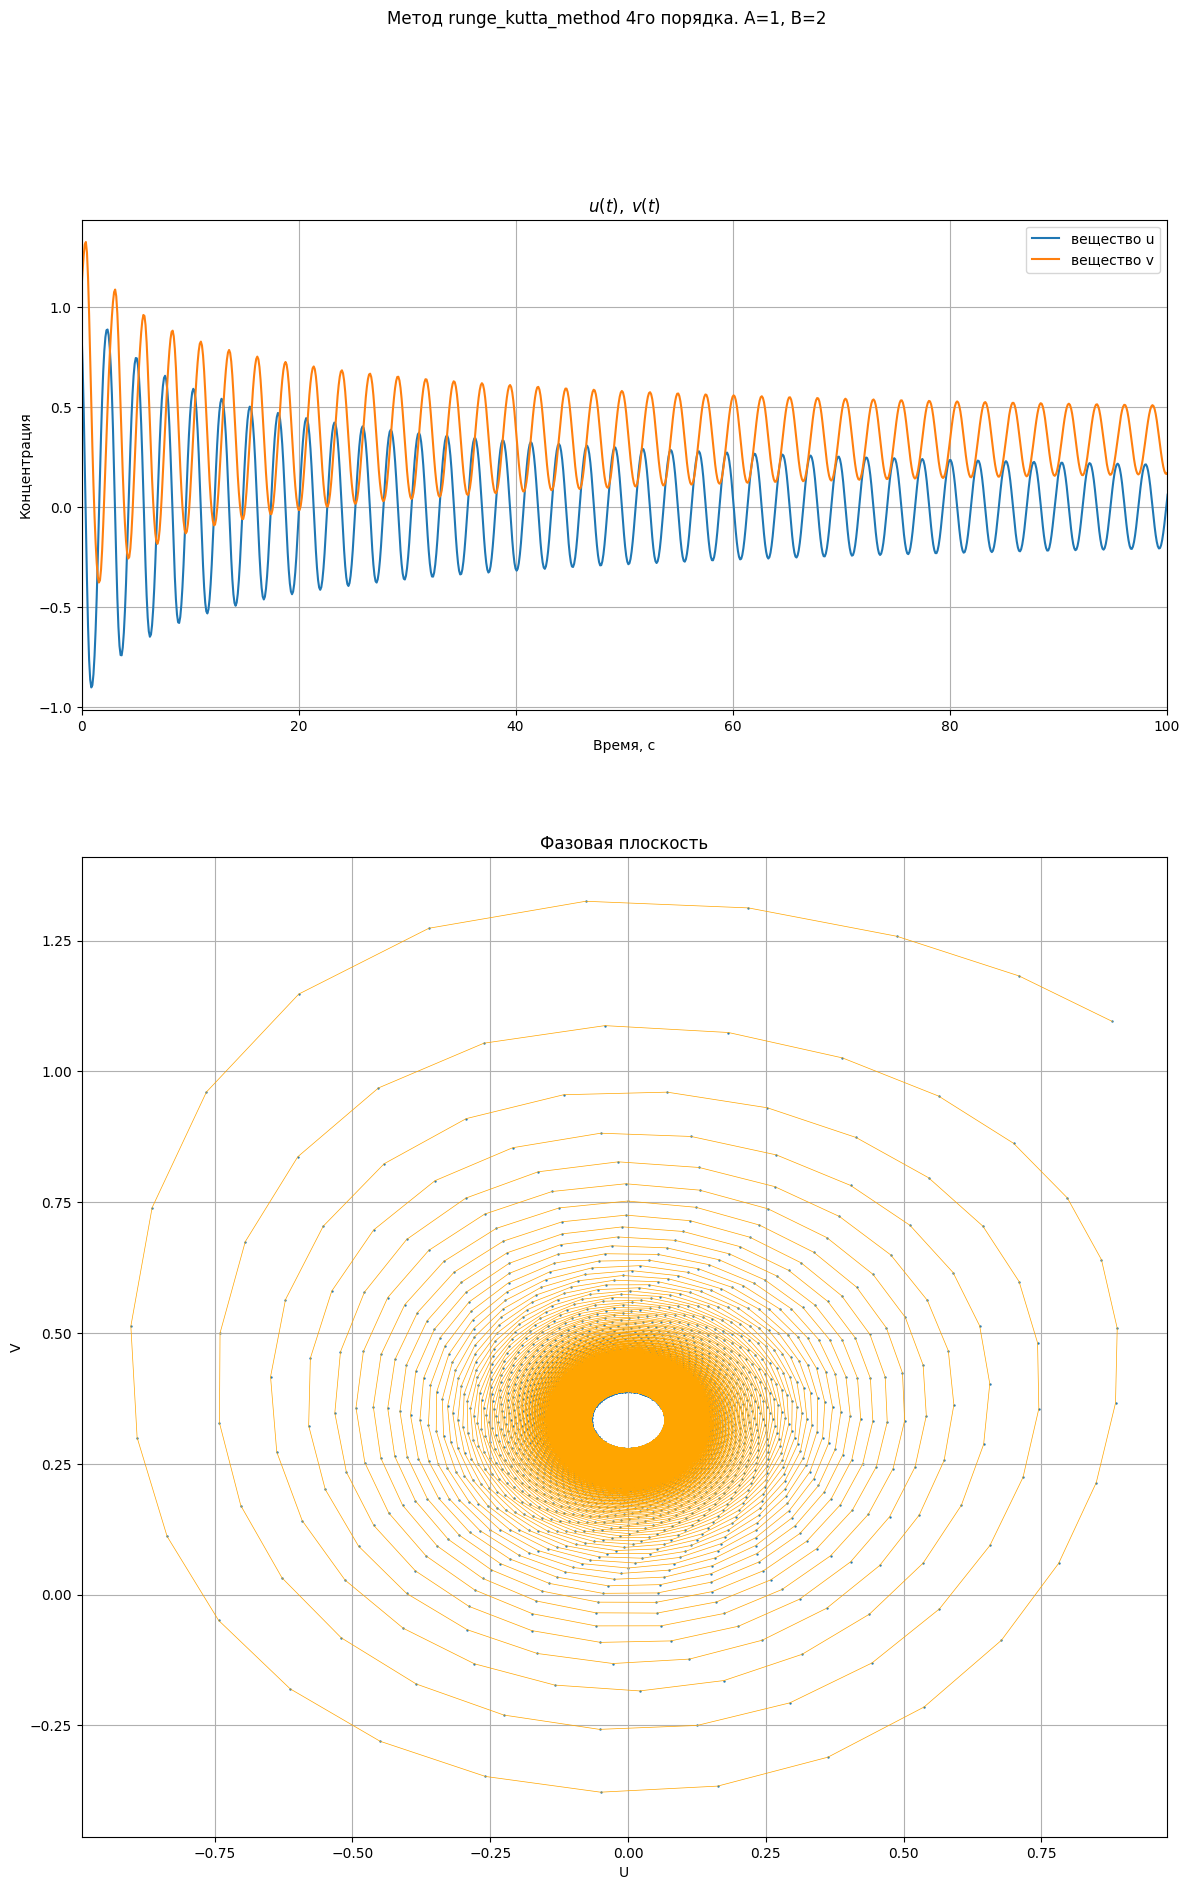

In [80]:
plot_results(runge_kutta_method)

### Метод Адамса-4

(4, 2)


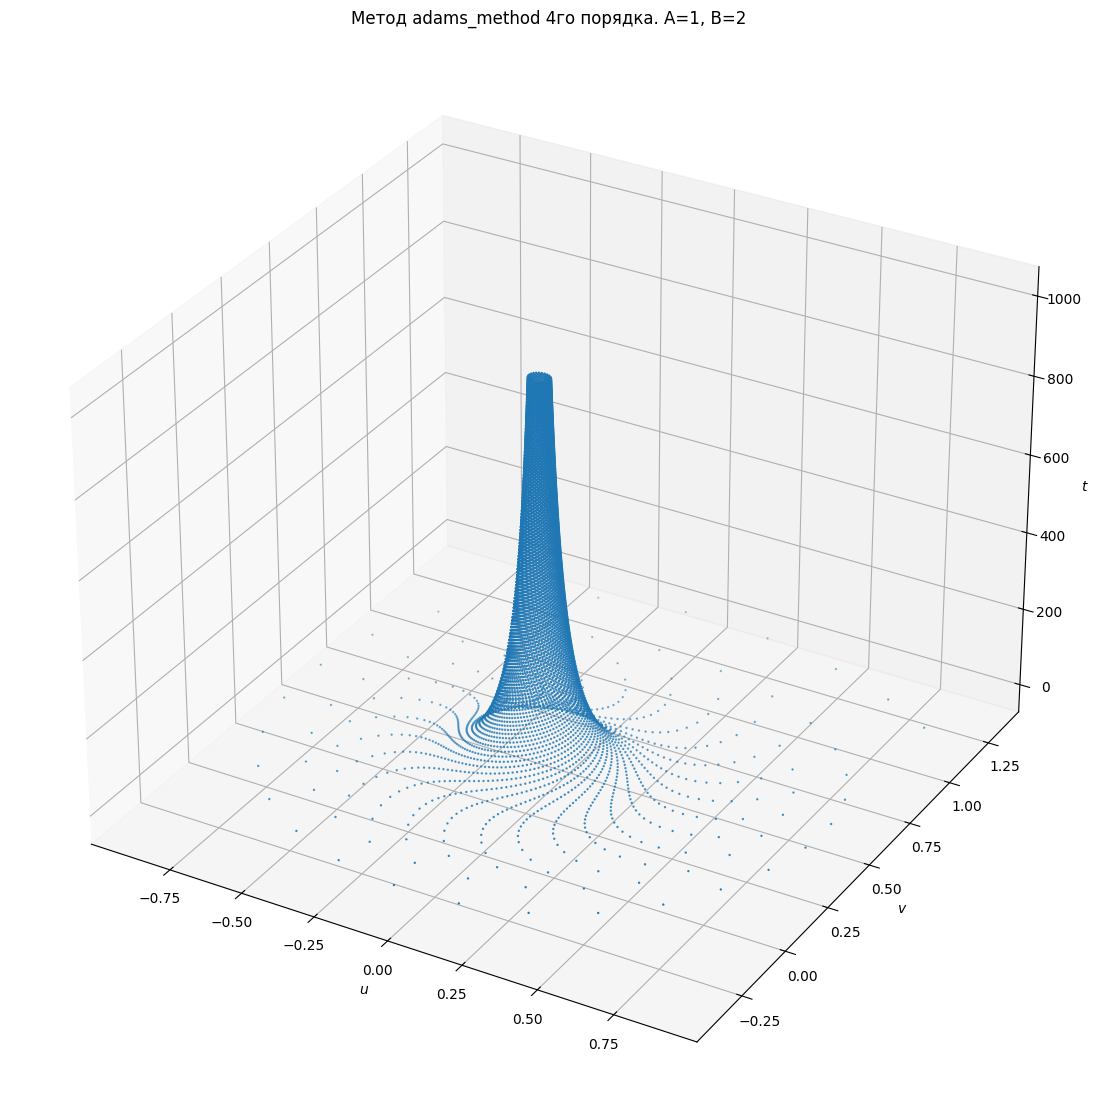

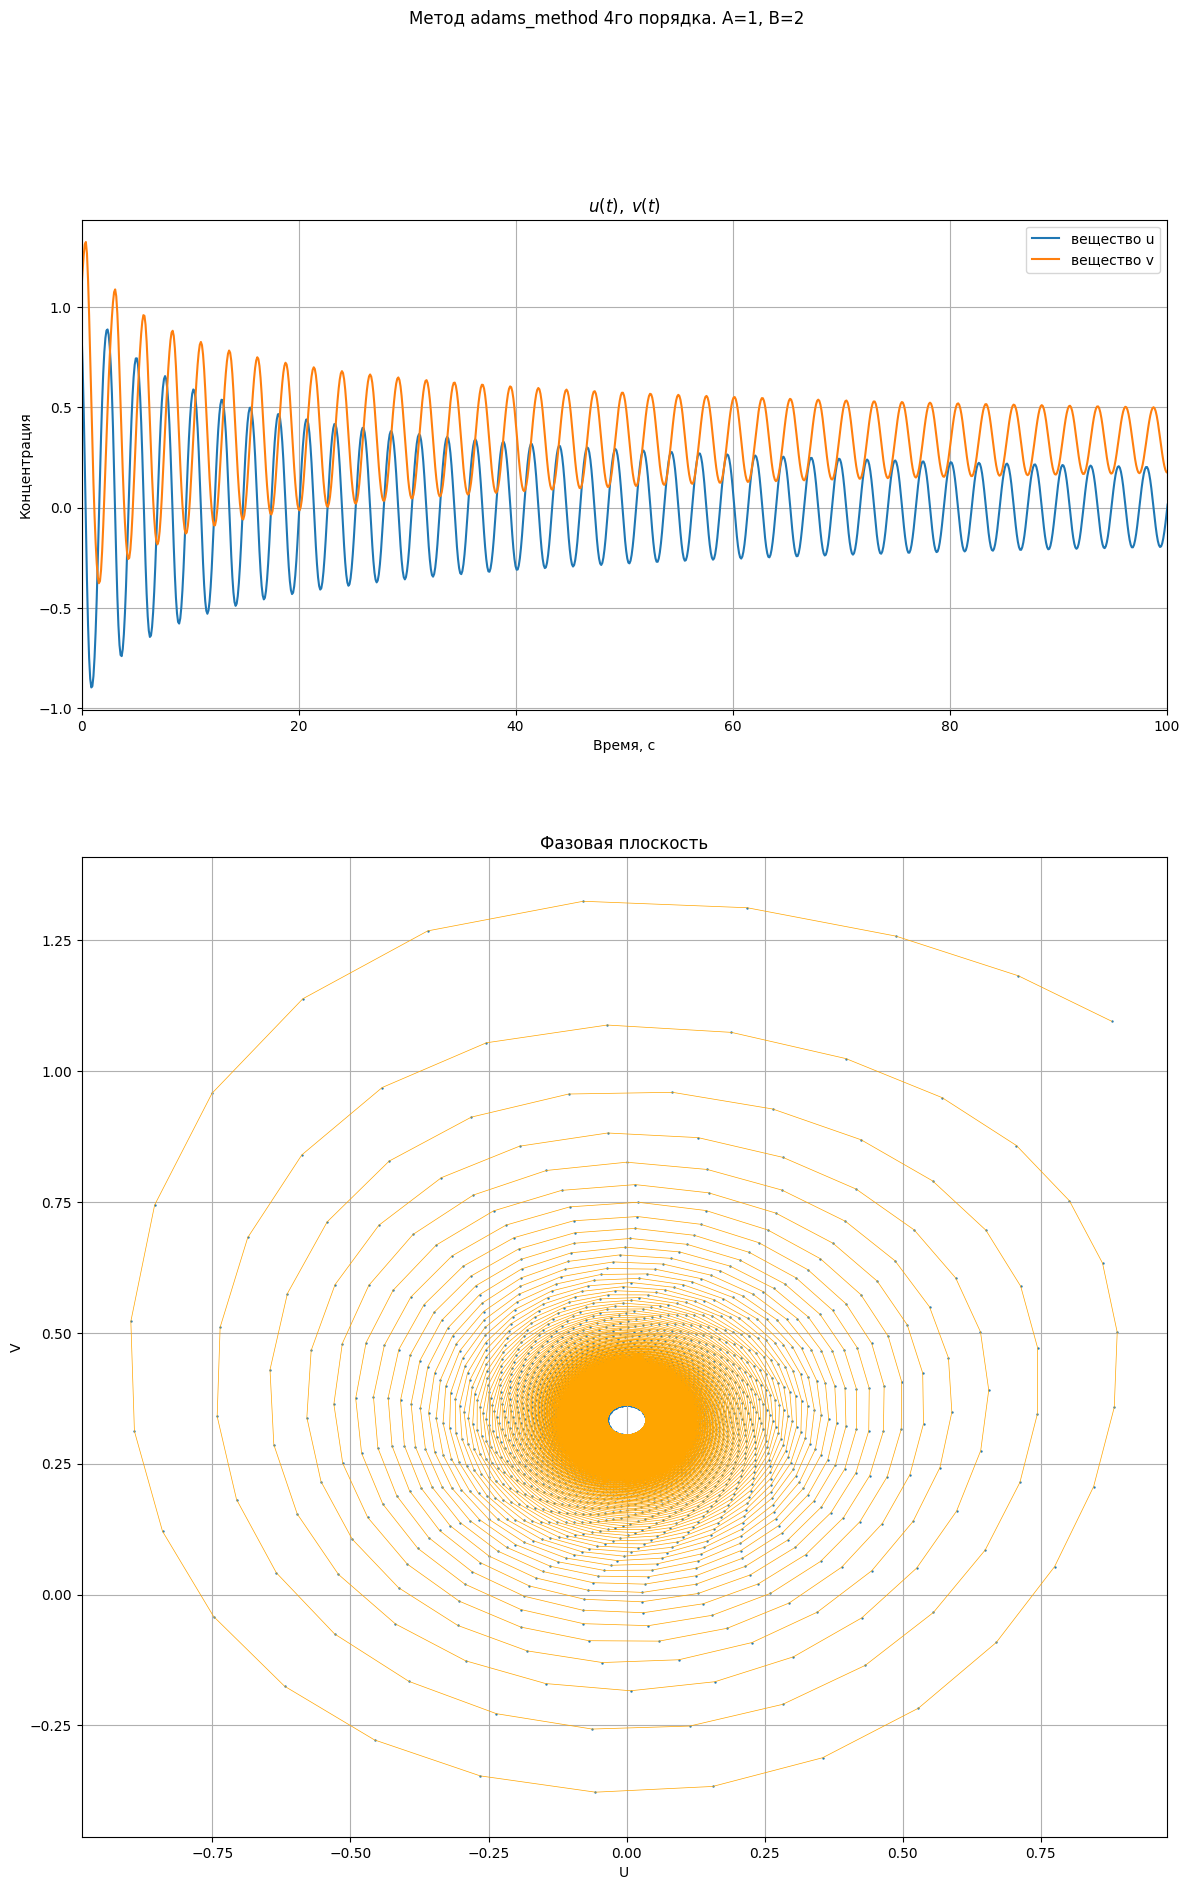

In [81]:
plot_results(adams_method)

### ФДН 3го порядка

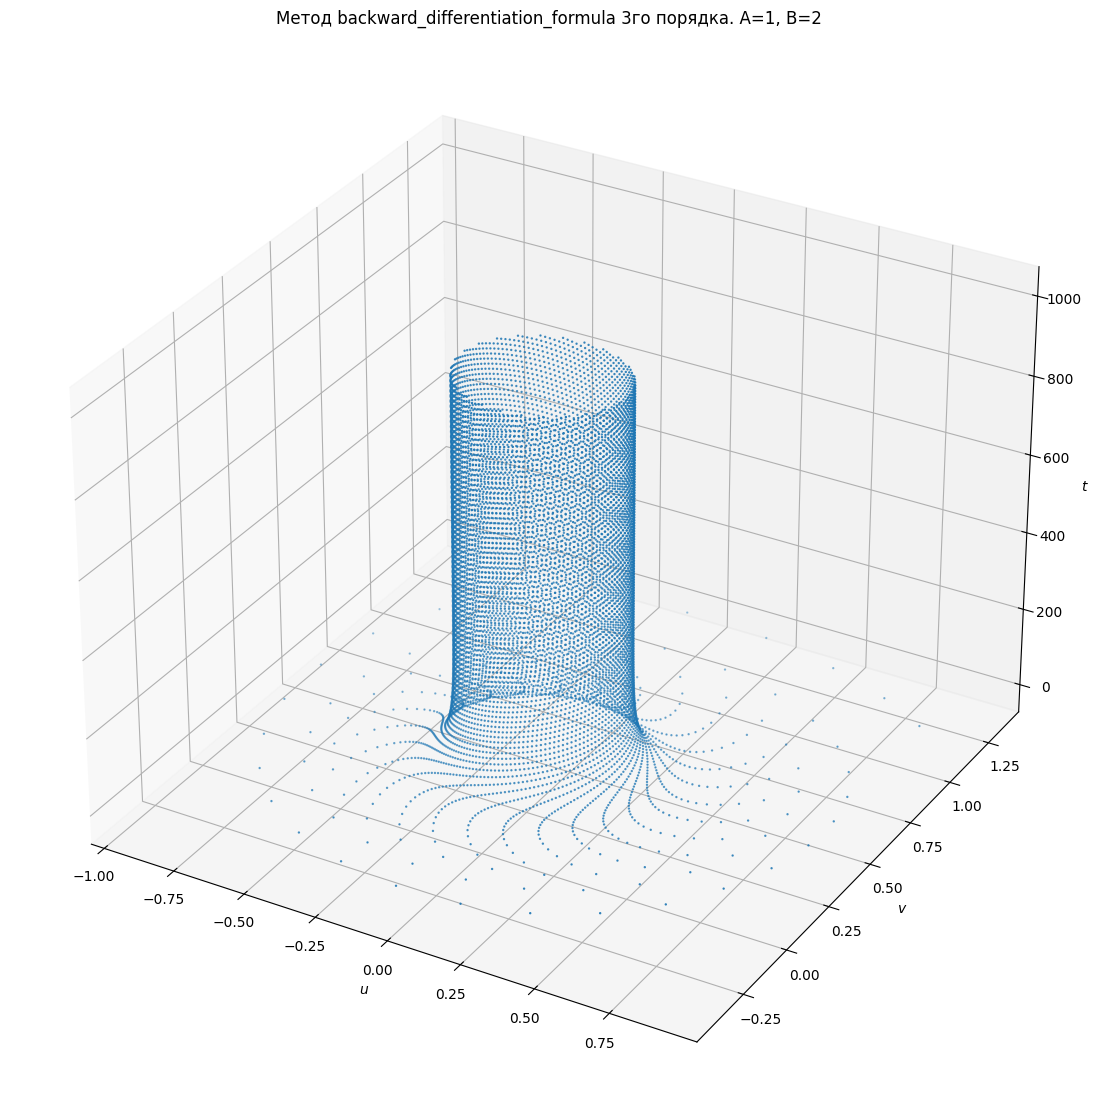

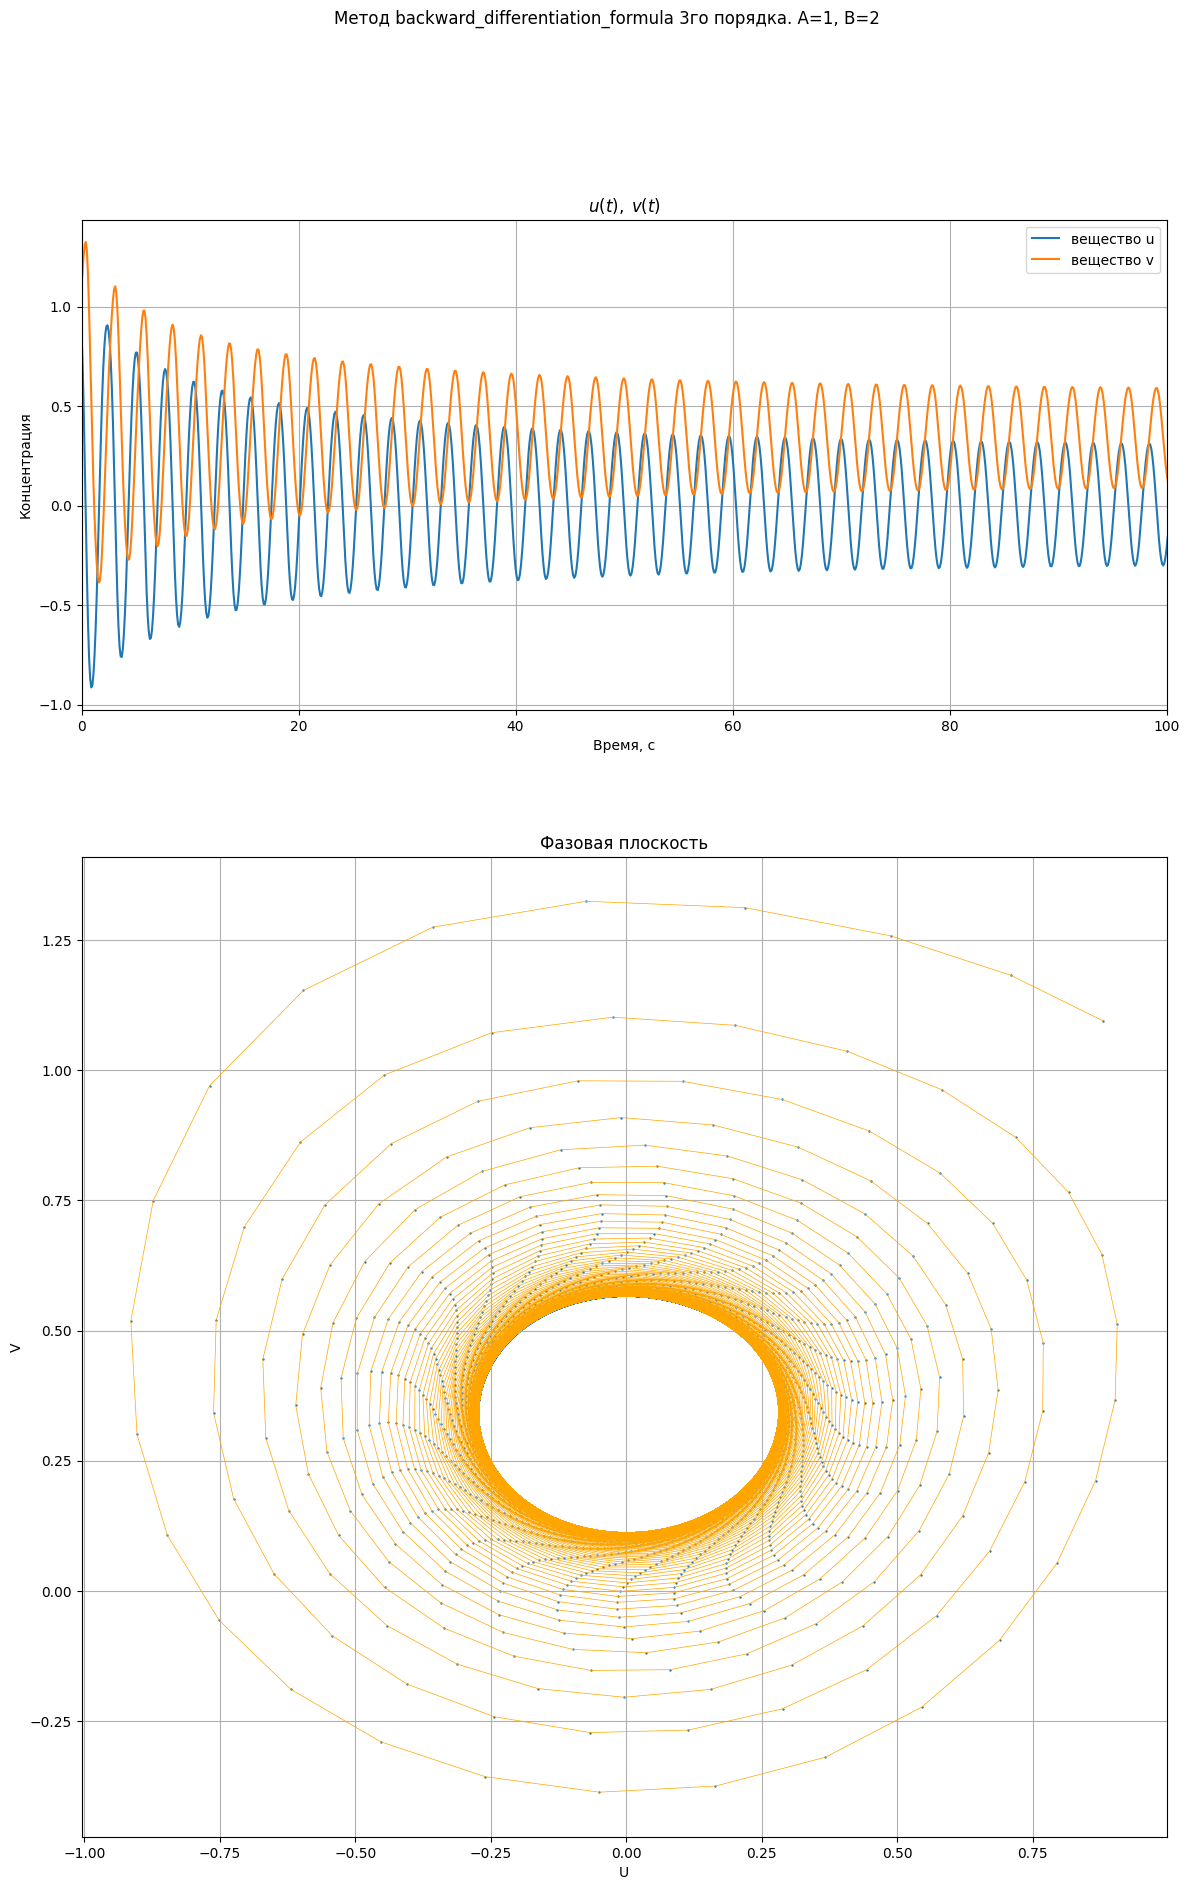

In [82]:
plot_results(backward_differentiation_formula, order=3)

## A = 1, B =3

In [83]:
A = 1
B = 3


### Метод РК-4:

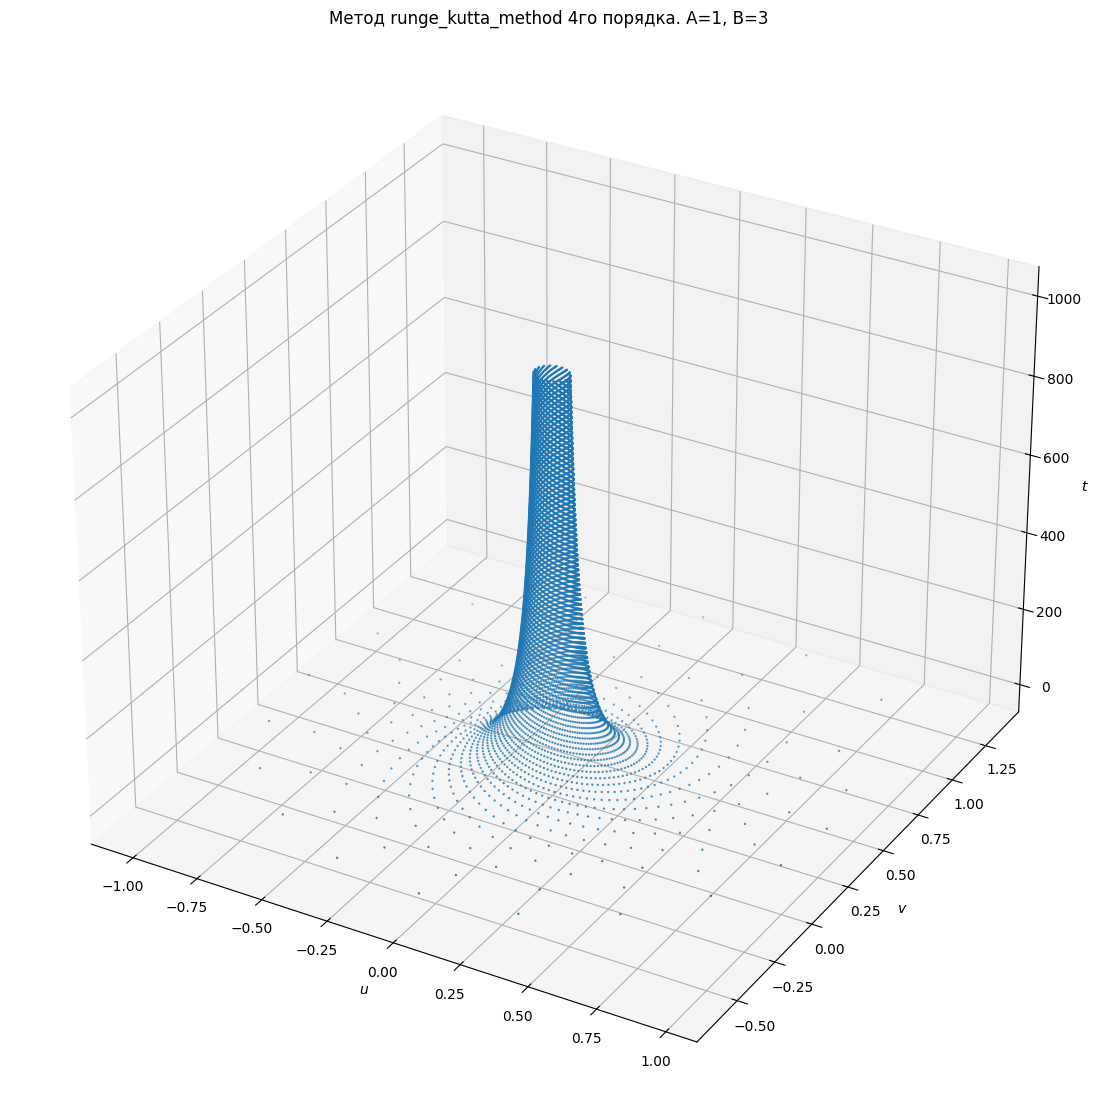

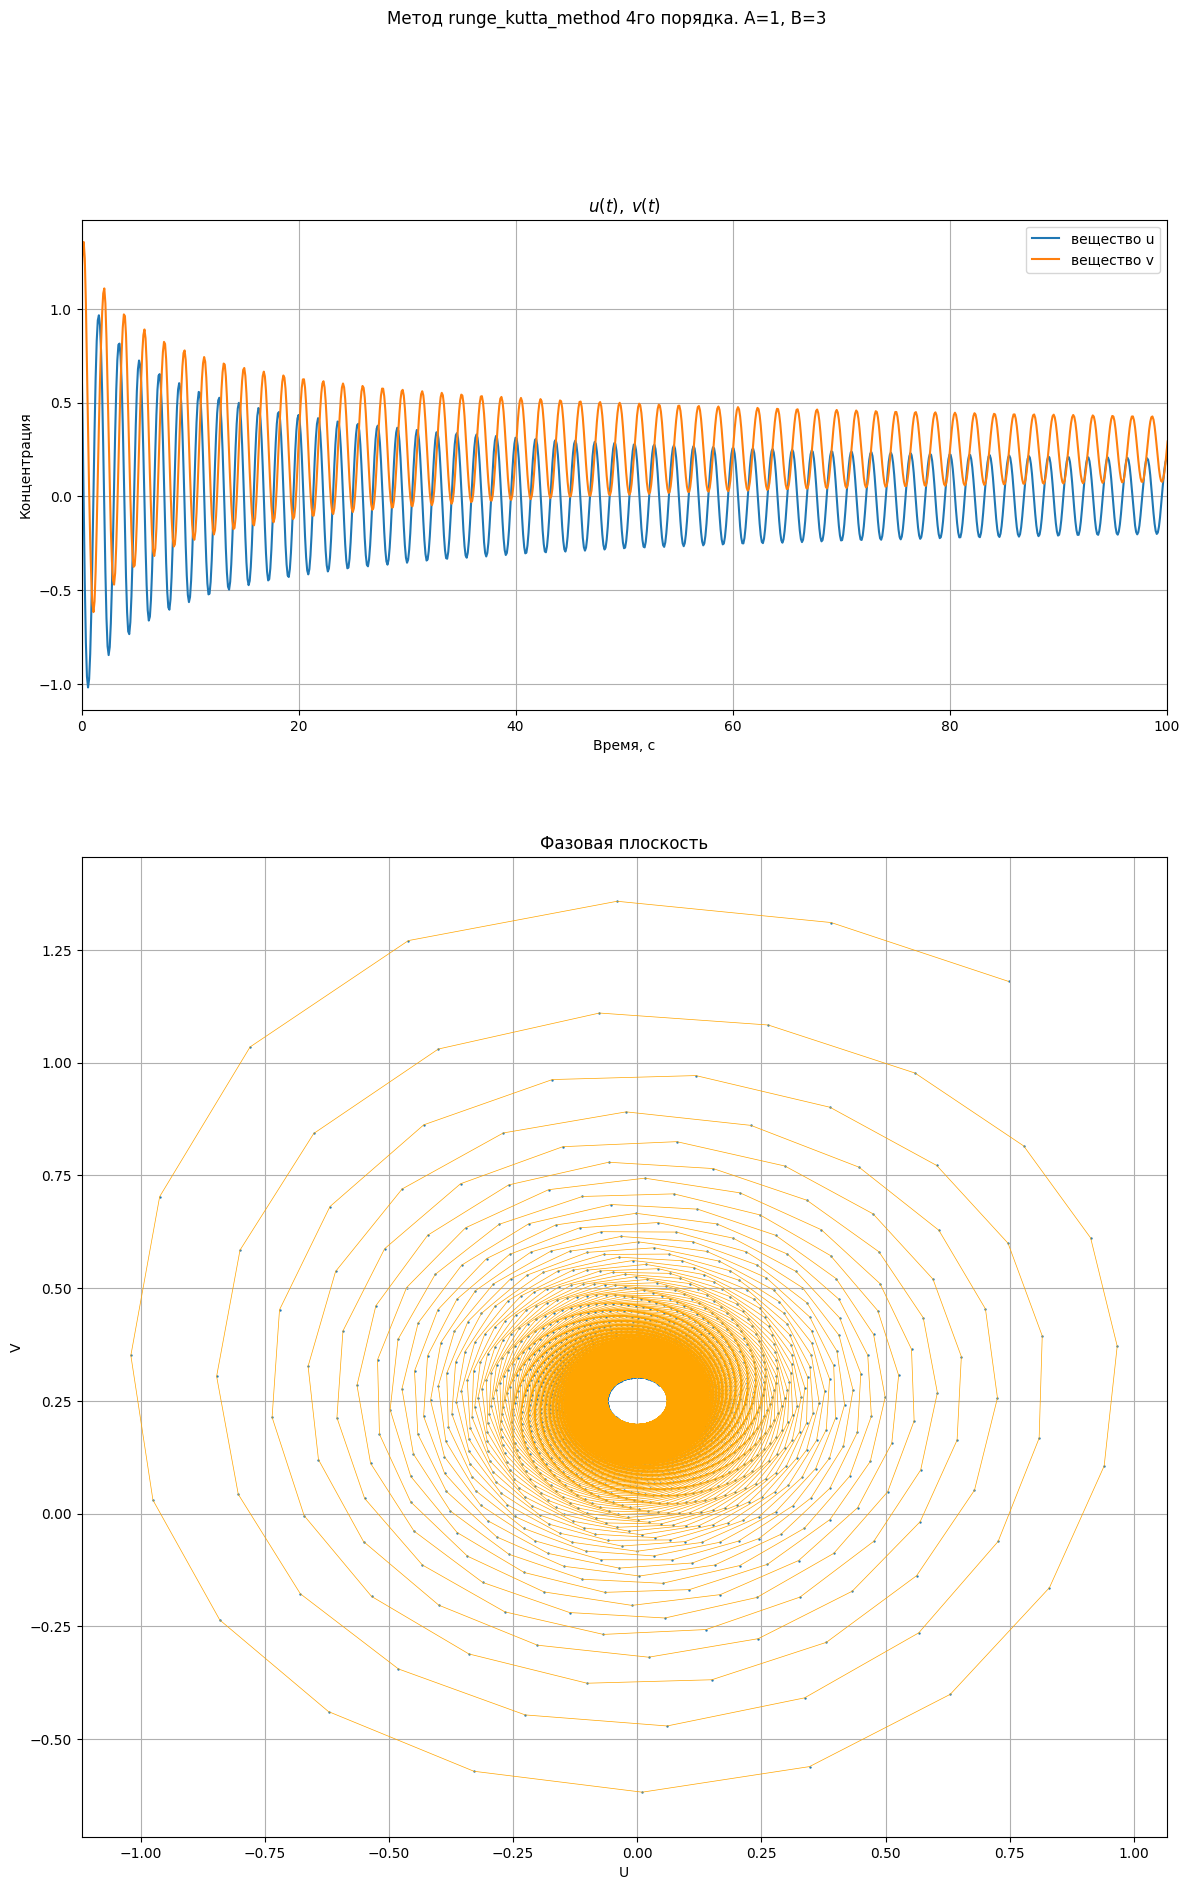

In [84]:
plot_results(runge_kutta_method)

### Метод Адамса-4

(4, 2)


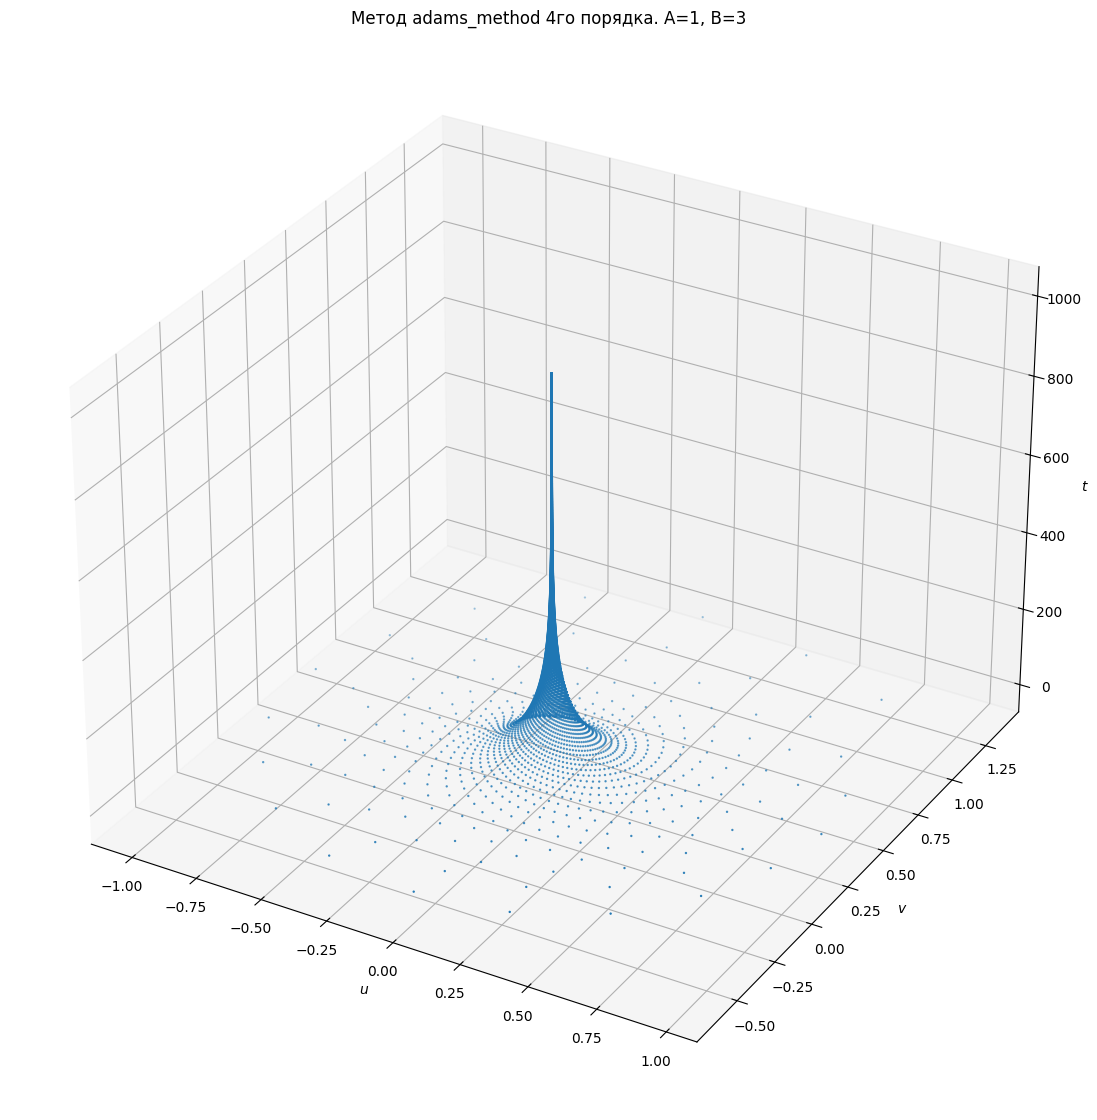

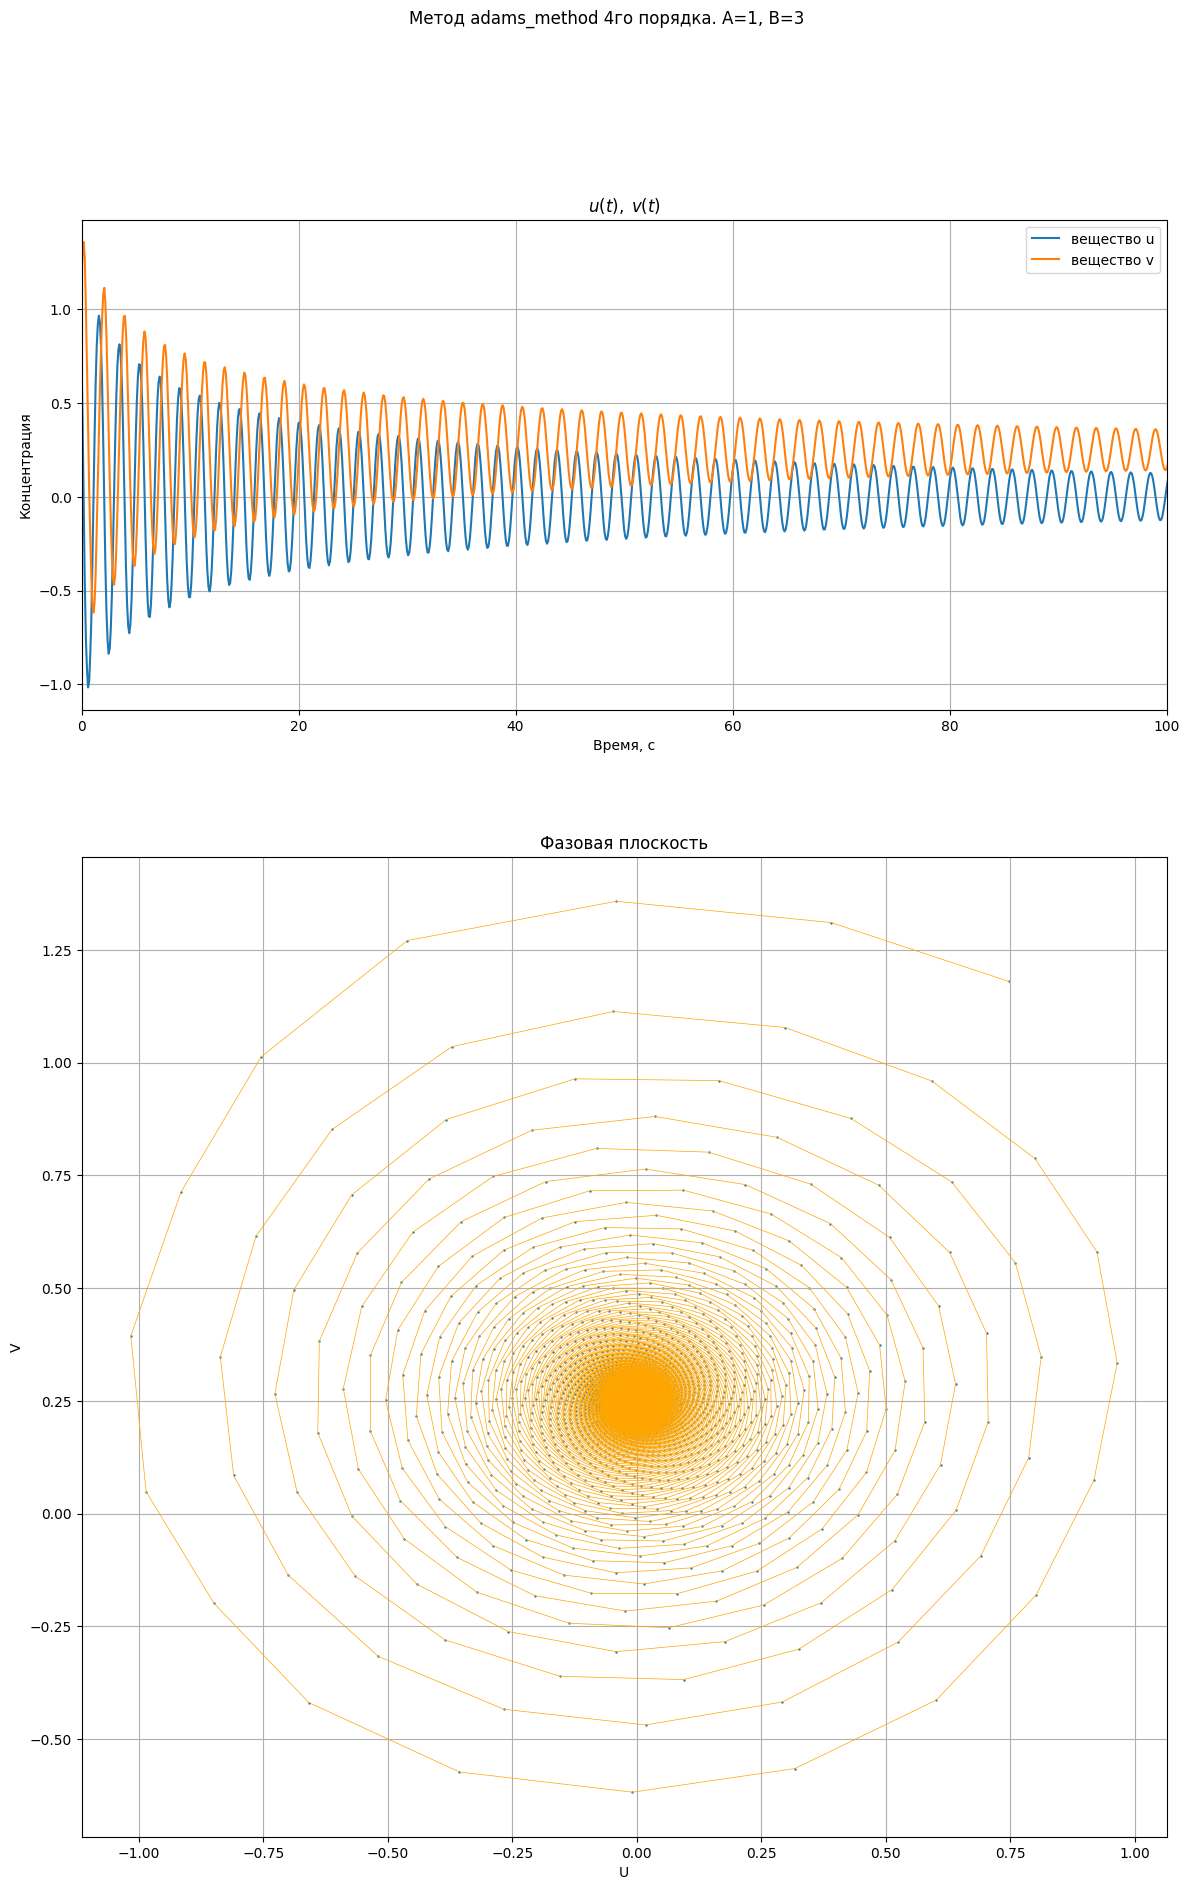

In [85]:
plot_results(adams_method)

### ФДН 3го порядка

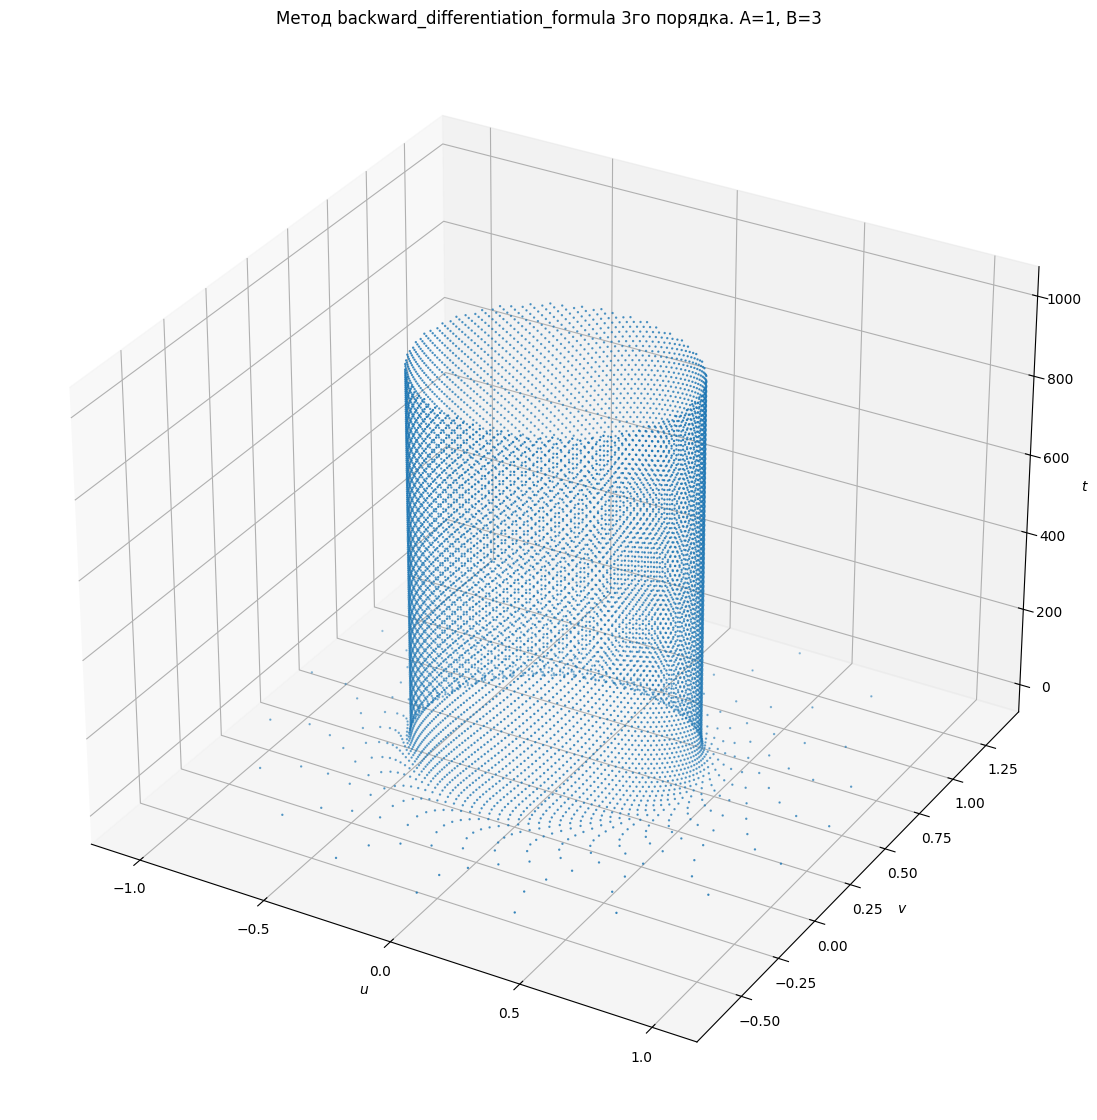

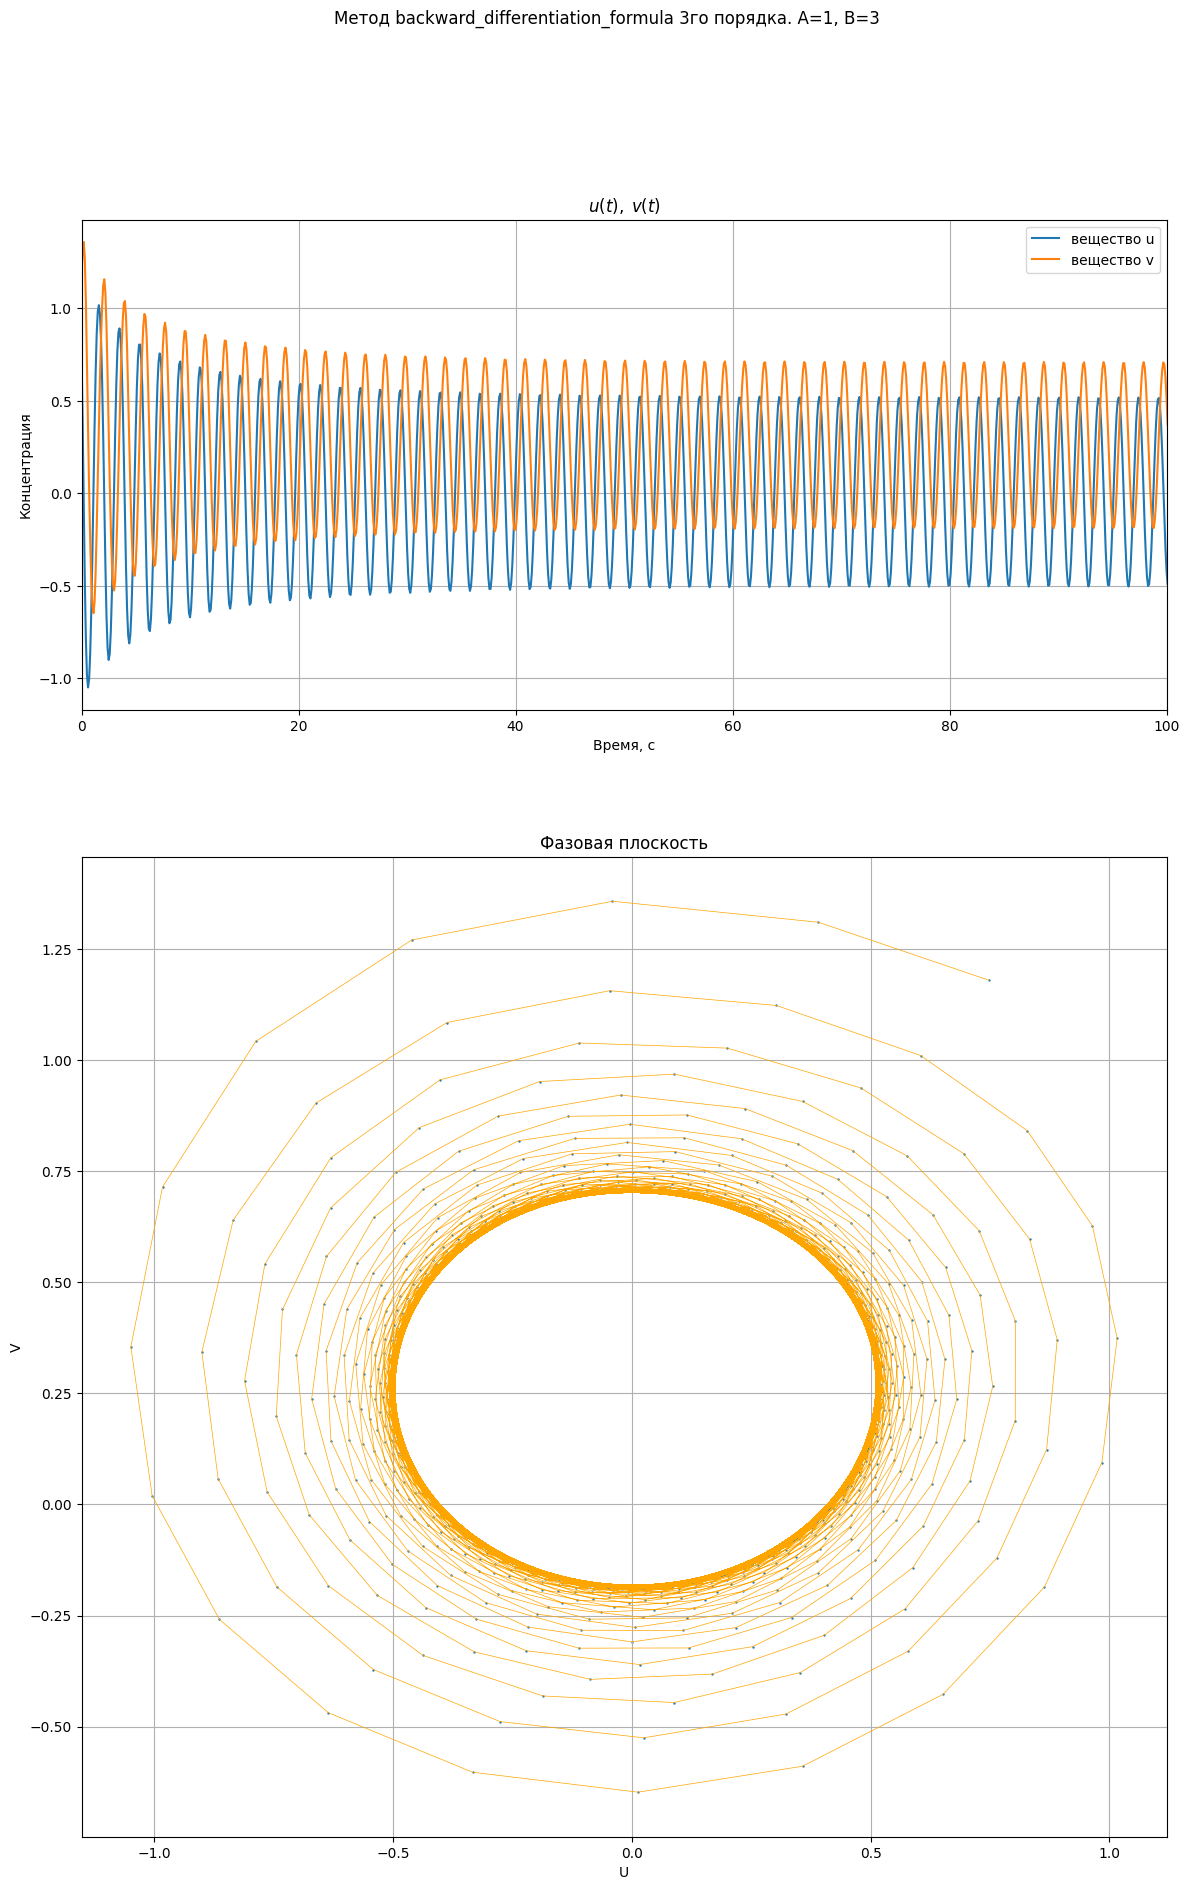

In [86]:
plot_results(backward_differentiation_formula, order=3)

## A = 1, B = 4

In [87]:
A = 1
B = 4


### Метод РК-4:

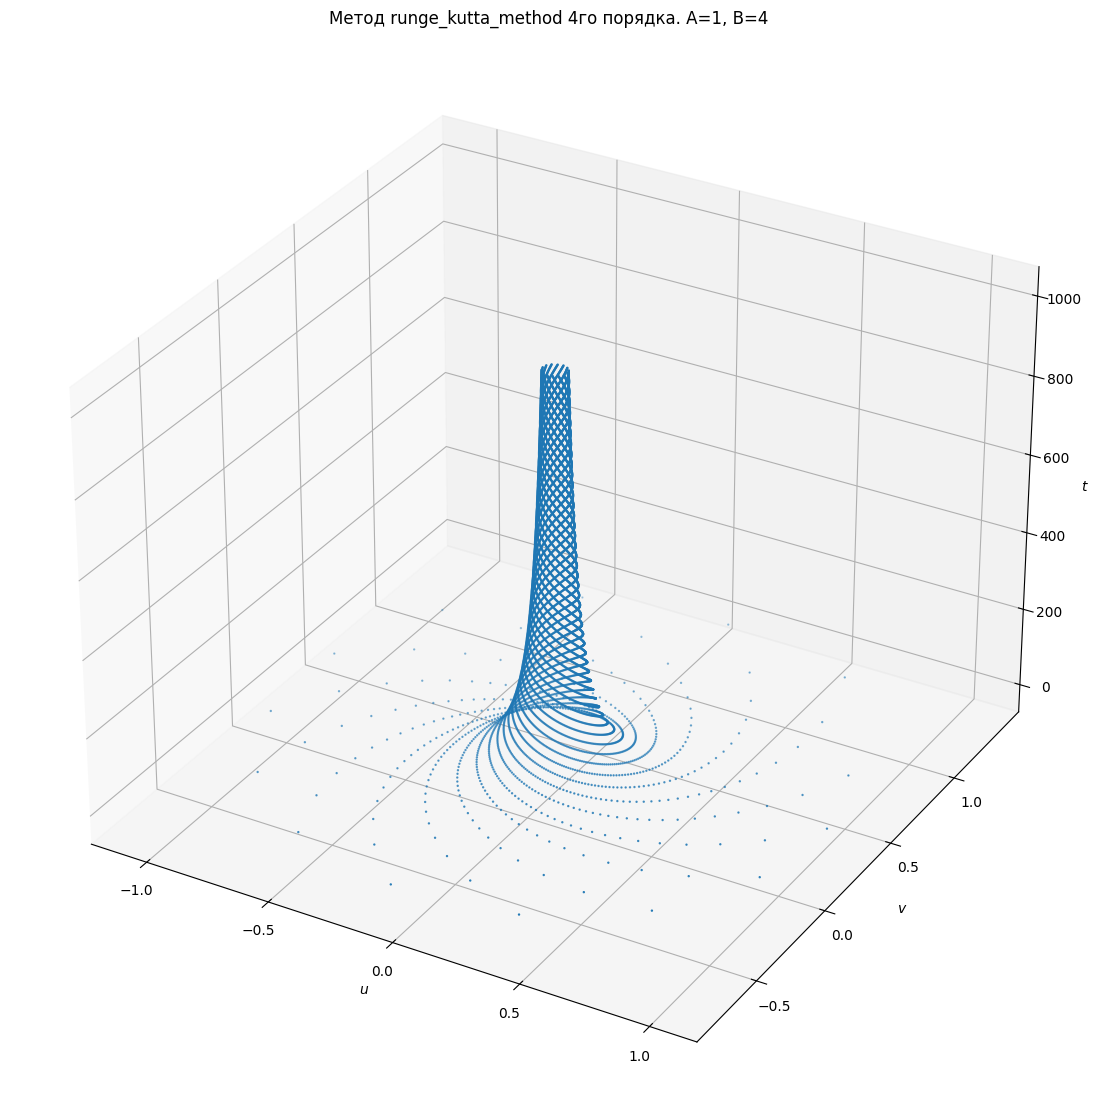

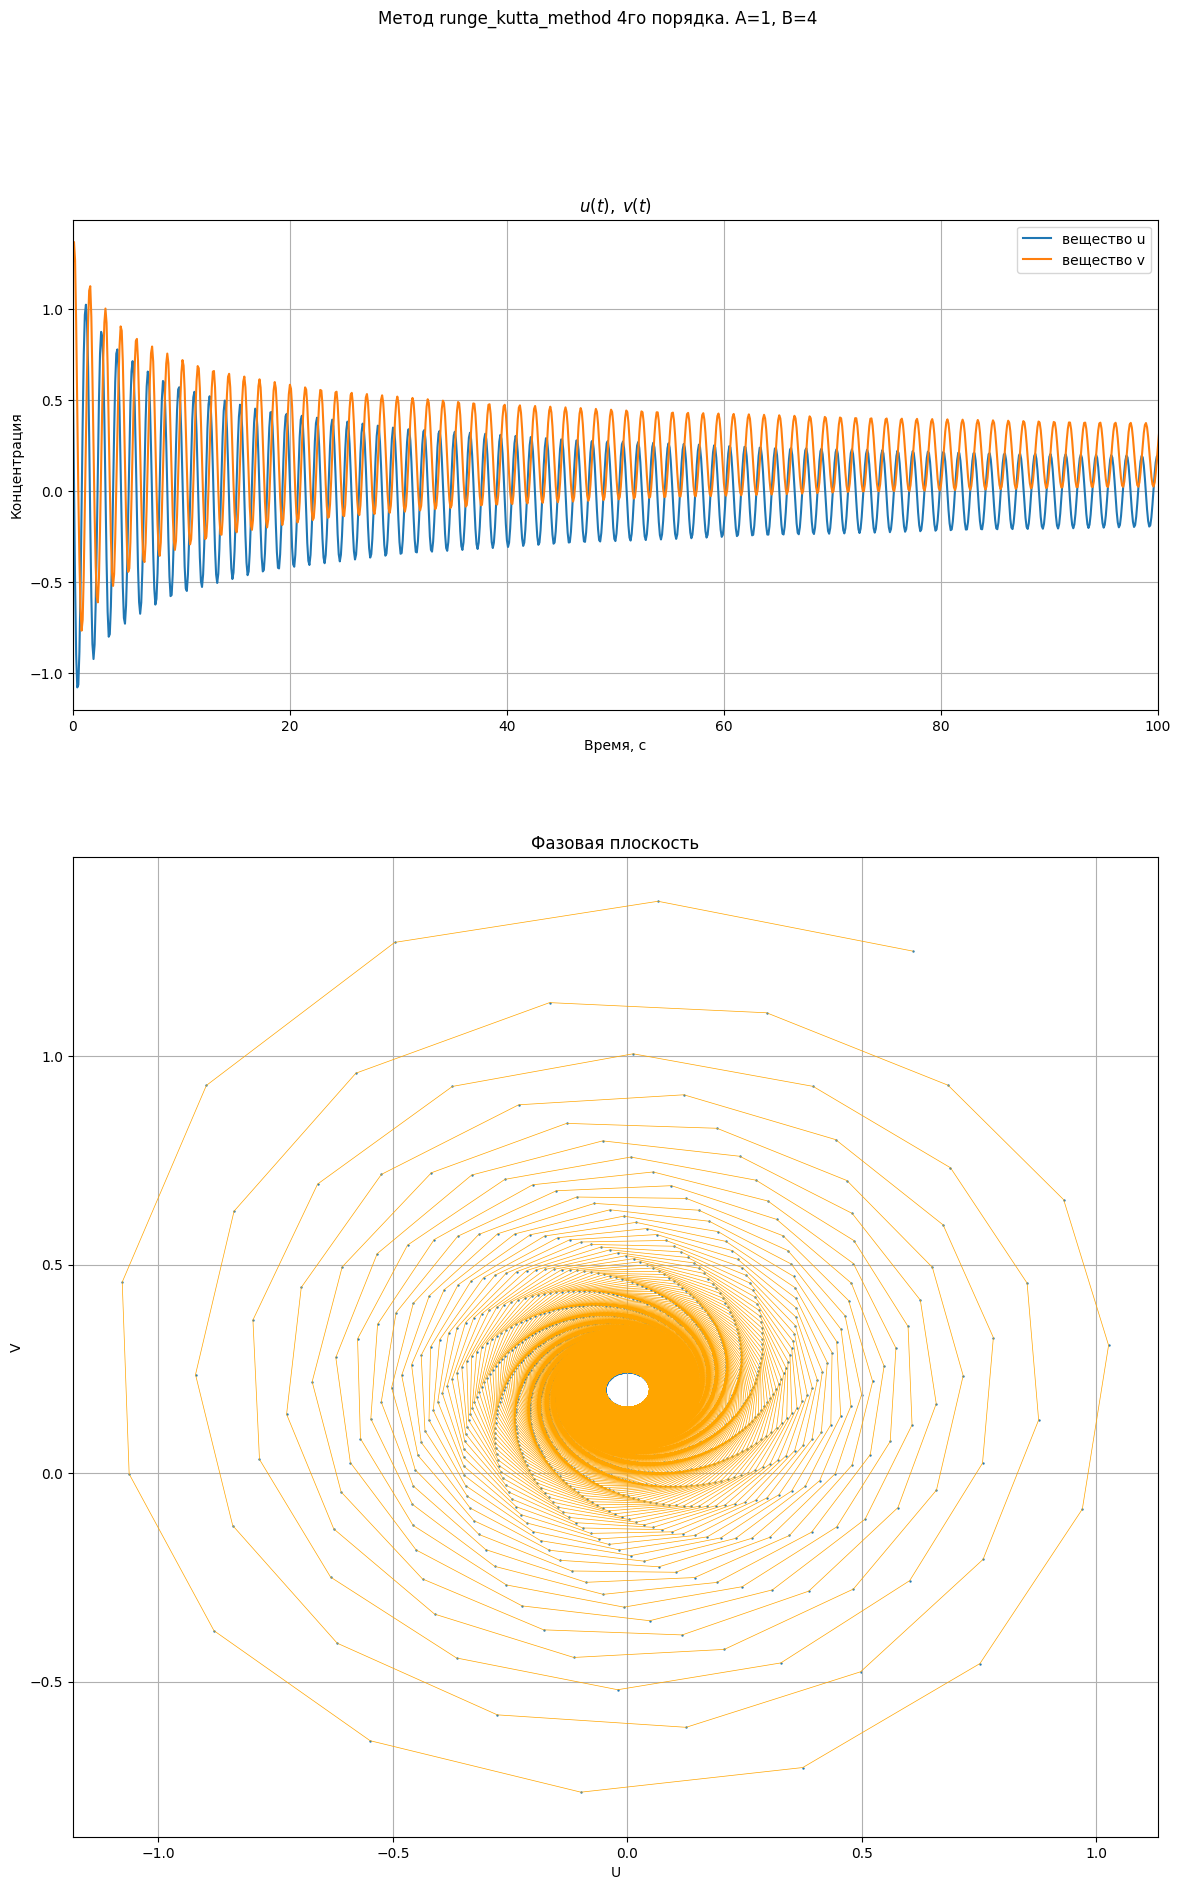

In [88]:
plot_results(runge_kutta_method)

### Метод Адамса-4

(4, 2)


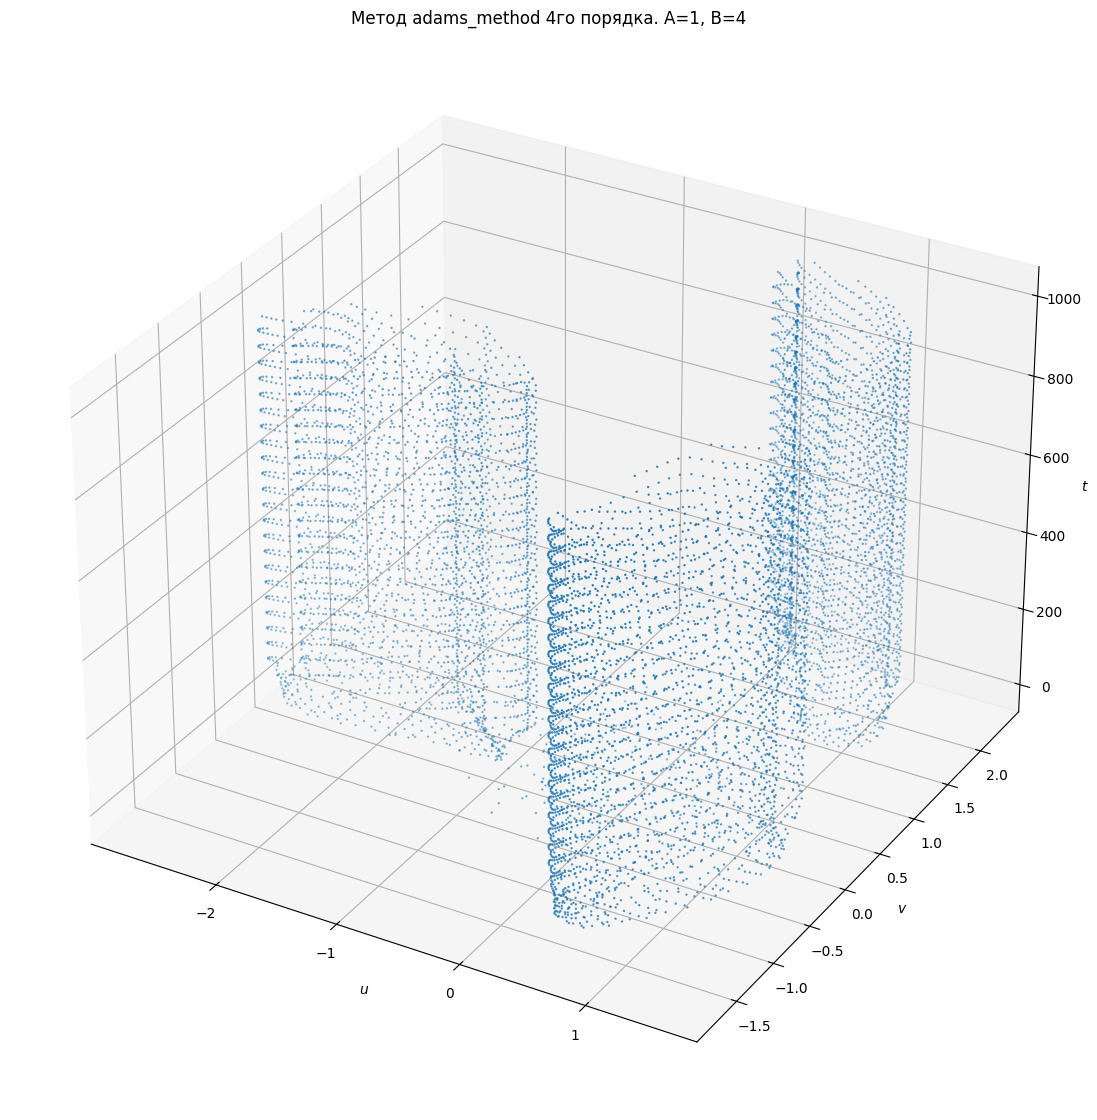

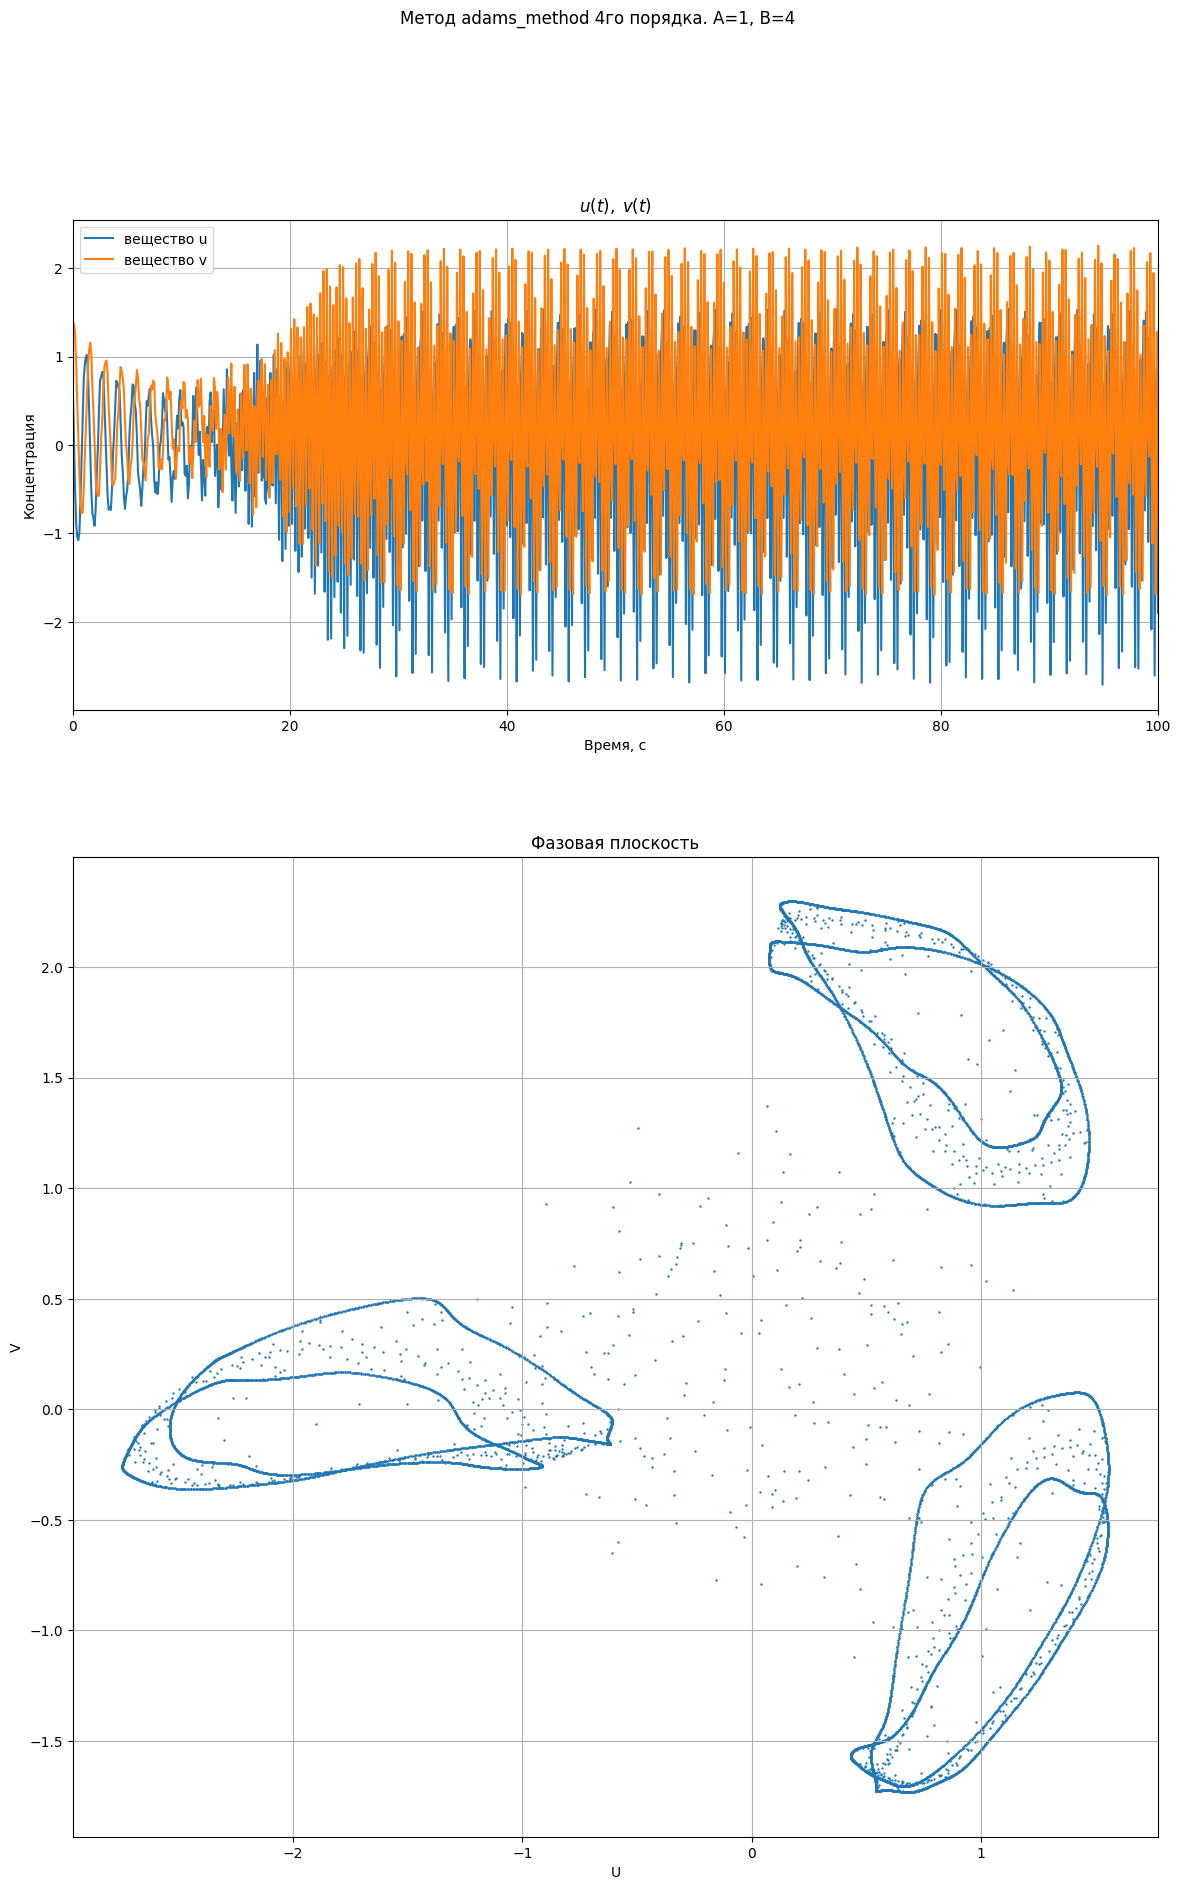

In [89]:
plot_results(adams_method, link_phase_plot_dots=False)

### ФДН 3го порядка

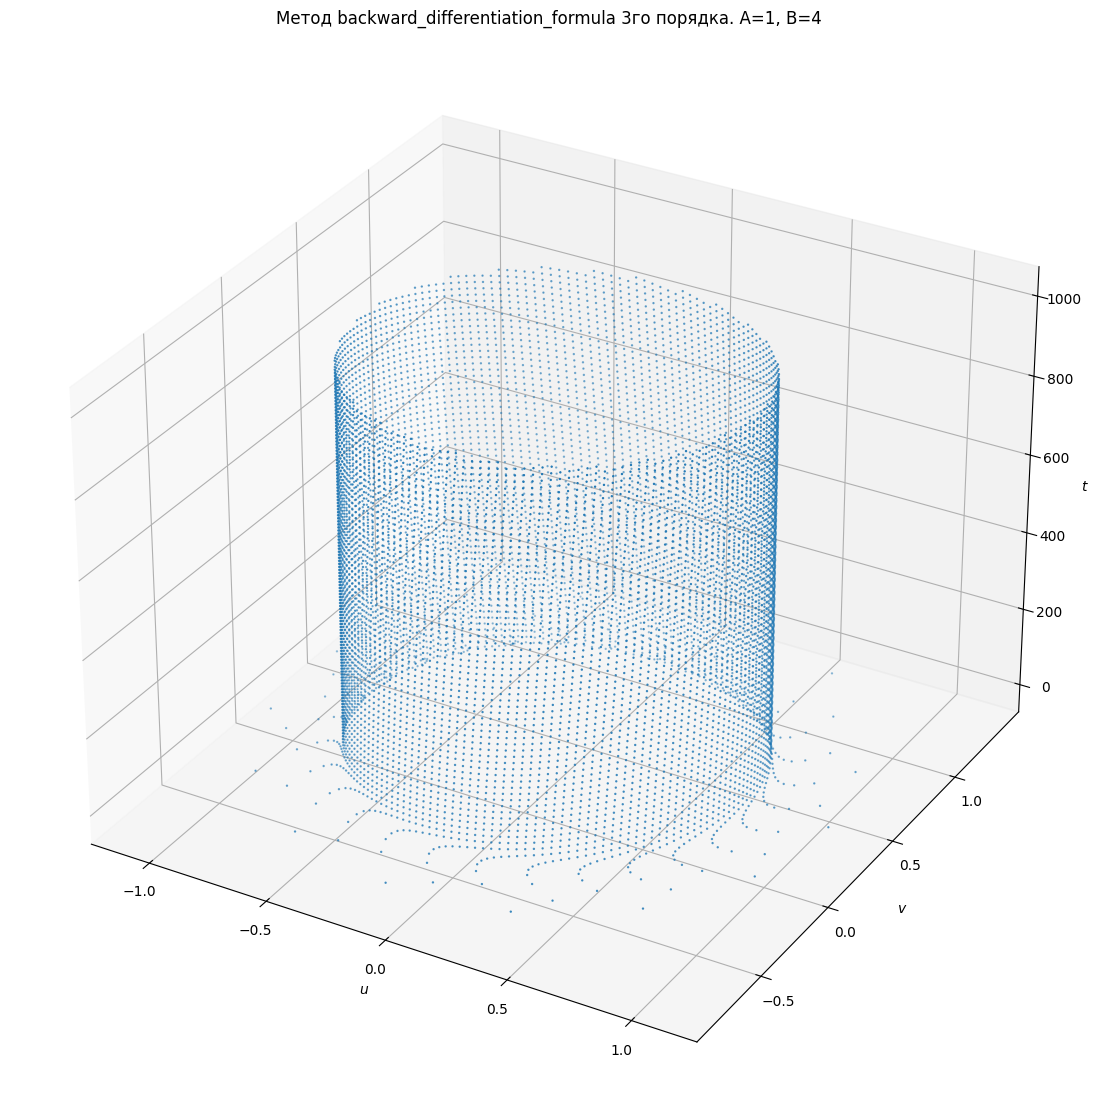

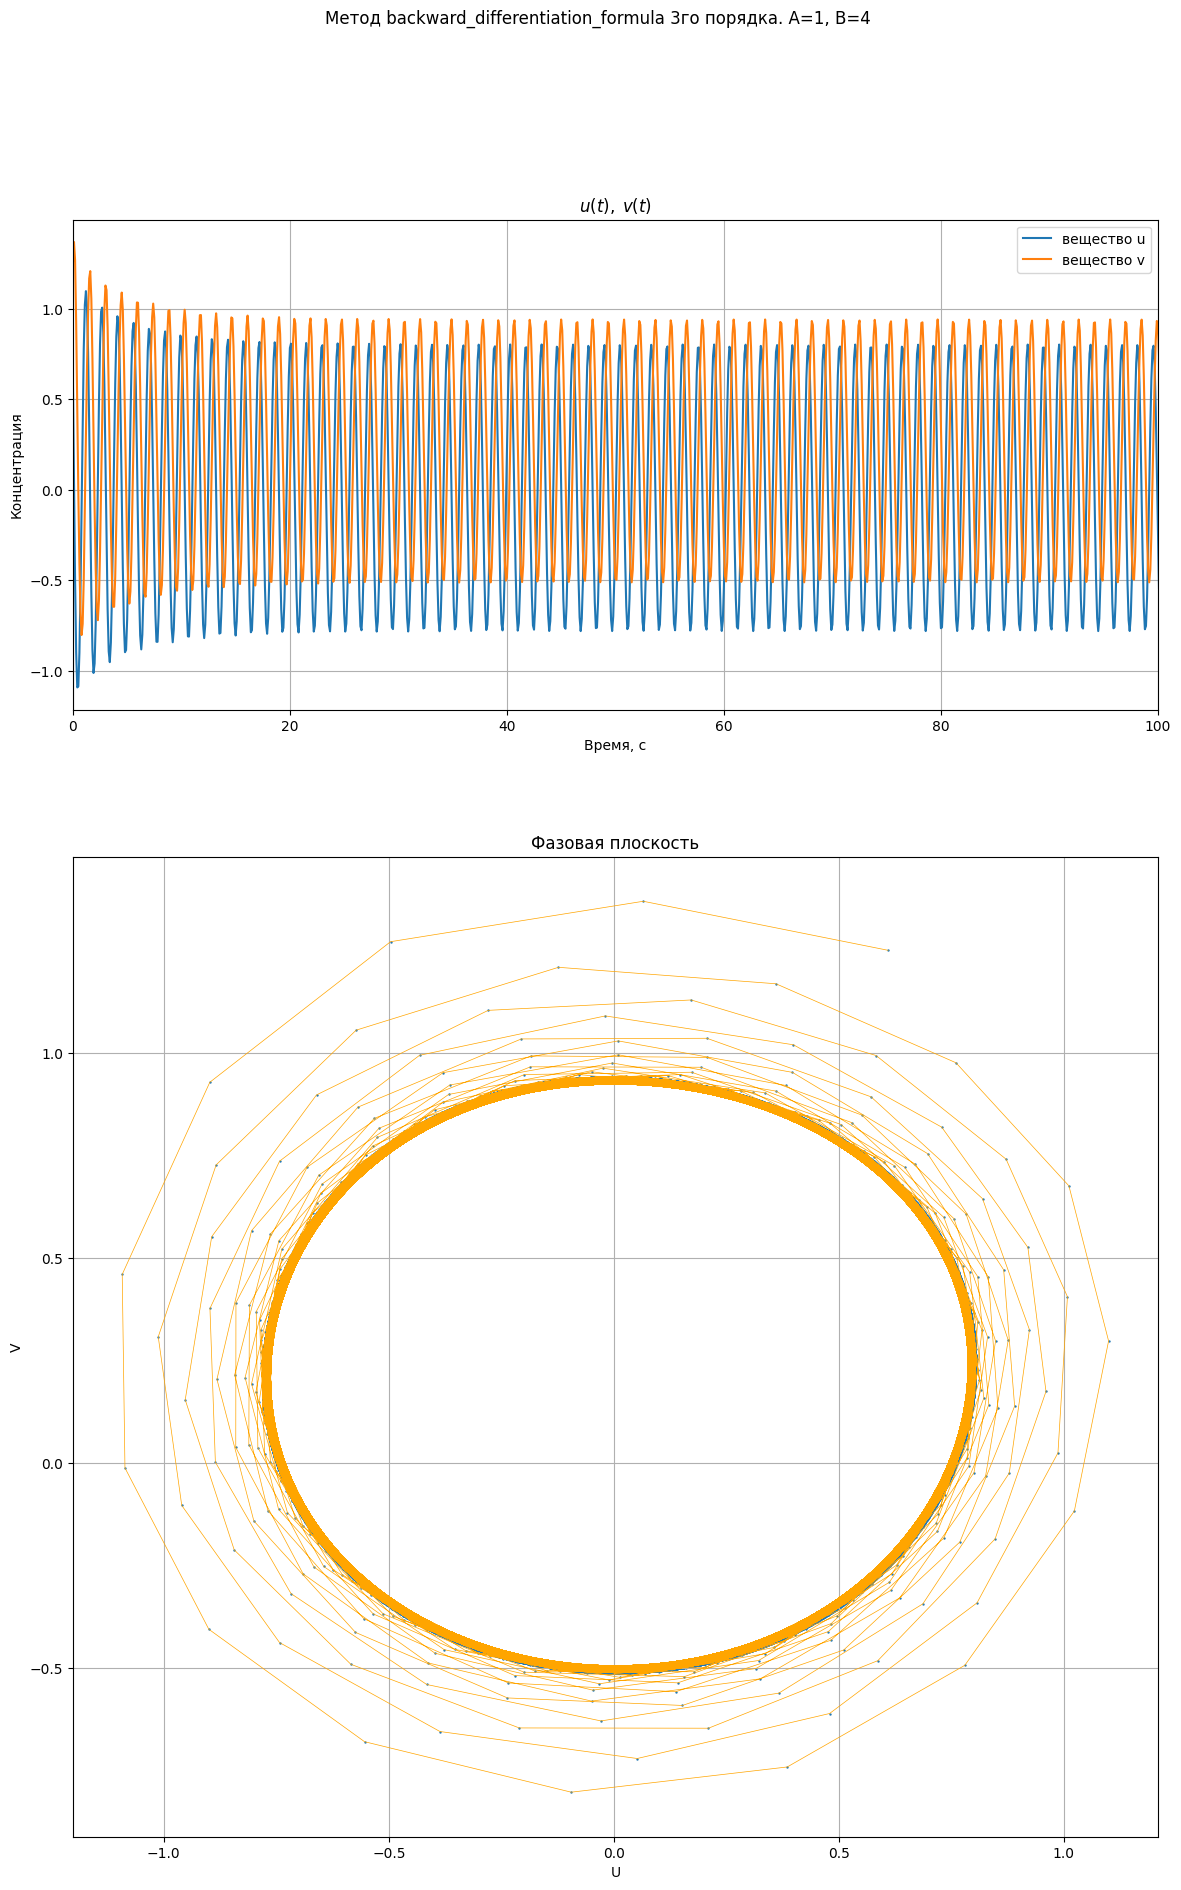

In [90]:
plot_results(backward_differentiation_formula, order=3)